In [1]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']
num_votazioni = 50
num_film = 5

In [2]:
#PRELEVO LE VARIE PRODUZIONI 
df_production = pd.DataFrame(db.production_companies.find({}))
df_production.head()

,_id,name
0,3,Pixar Animation Studios
1,559,TriStar Pictures
2,2550,Teitler Film
3,10201,Interscope Communications
4,6194,Warner Bros.


In [3]:
df_production = df_production.rename(columns= {'_id' : 'production_companies'})

In [4]:
#PRELEVO I VARI FILM
df_film= pd.DataFrame( db.metadata.aggregate([ {'$project': {'_id': 1, 'production_companies': 1,'vote_average':1,'vote_count':1,'budget':1,'original_title':1,'revenue':1}
    }]))
df_film

,_id,budget,original_title,production_companies,revenue,vote_average,vote_count
0,862,30000000,Toy Story,[3],373554033.0,7.7,5415.0
1,8844,65000000,Jumanji,"[559, 2550, 10201]",262797249.0,6.9,2413.0
2,15602,0,Grumpier Old Men,"[6194, 19464]",0.0,6.5,92.0
3,31357,16000000,Waiting to Exhale,[306],81452156.0,6.1,34.0
4,11862,0,Father of the Bride Part II,"[5842, 9195]",76578911.0,5.7,173.0
...,...,...,...,...,...,...,...
45428,439050,0,رگ خواب,None,0.0,4.0,1.0
45429,111109,0,Siglo ng Pagluluwal,[19653],0.0,9.0,3.0
45430,67758,0,Betrayal,[6165],0.0,3.8,6.0
45431,227506,0,Satana likuyushchiy,[88753],0.0,0.0,0.0


In [5]:
#CONVERTO BUDGET IN INTERO
df_film.budget = df_film.budget.astype(str).astype(int)

In [6]:
#CONVERTO _ID IN INTERO
df_film._id = df_film._id.astype(str).astype(int)

In [7]:
#utilizzo funzione explode, per creare nuove righe dagli elementi dell' array presenti nella colonna genres
df_film = df_film.explode('production_companies')



In [8]:
#FILTRO, PRELEVANDO SOLO I FILM CHE HANNO AVUTO UN CERTO NUMERO DI VOTI
df_film = df_film.mask(df_film.eq('None')).dropna()
df_film = df_film.loc[df_film['vote_count'] >= num_votazioni]
df_film = df_film.loc[df_film['revenue'] > 0.0]


C:\Users\monob\anaconda3\envs\py37\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\monob\anaconda3\envs\py37\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [9]:
#CONTROLLO CHE NON CI SIANO NULL 
df_film.isna().sum()

_id                     0
budget                  0
original_title          0
production_companies    0
revenue                 0
vote_average            0
vote_count              0
dtype: int64

In [10]:
(df_film.production_companies=="None").value_counts()

False    16873
Name: production_companies, dtype: int64

In [11]:
#ELIMINO LE RIGHE CHE HANNO BUDGET 0
index_target = df_film[ df_film.budget == 0 ].index


In [12]:
df_film.drop(index_target , inplace=True)

    

In [13]:
df_film

,_id,budget,original_title,production_companies,revenue,vote_average,vote_count
0,862,30000000,Toy Story,3,373554033.0,7.7,5415.0
1,8844,65000000,Jumanji,559,262797249.0,6.9,2413.0
1,8844,65000000,Jumanji,2550,262797249.0,6.9,2413.0
1,8844,65000000,Jumanji,10201,262797249.0,6.9,2413.0
5,949,60000000,Heat,508,187436818.0,7.7,1886.0
...,...,...,...,...,...,...,...
45107,378236,50000000,The Emoji Movie,5,66913939.0,5.8,327.0
45107,378236,50000000,The Emoji Movie,2251,66913939.0,5.8,327.0
45135,395834,11000000,Wind River,3528,184770205.0,7.4,181.0
45135,395834,11000000,Wind River,27497,184770205.0,7.4,181.0


In [14]:
#CONVERTO REVENUE IN INTERO
df_film.revenue = df_film.revenue.astype(float).astype(int)

In [15]:
#FACCIO JOIN CON IL DATAFRAME CONTENENTE LE PRODUZIONI
df_H1 = pd.merge(df_film, df_production, on='production_companies')

df_H1


,_id,budget,original_title,production_companies,revenue,vote_average,vote_count,name
0,862,30000000,Toy Story,3,373554033,7.7,5415.0,Pixar Animation Studios
1,9487,120000000,A Bug's Life,3,363258859,6.8,2379.0,Pixar Animation Studios
2,863,90000000,Toy Story 2,3,497366869,7.3,3914.0,Pixar Animation Studios
3,585,115000000,"Monsters, Inc.",3,562816256,7.5,6150.0,Pixar Animation Studios
4,12,94000000,Finding Nemo,3,940335536,7.6,6292.0,Pixar Animation Studios
...,...,...,...,...,...,...,...,...
14167,293768,21000000,Kidnap,92395,24527158,6.0,244.0,Rumble Entertainment
14168,341013,30000000,Atomic Blonde,87733,90007945,6.1,748.0,Closed on Mondays Entertainment
14169,374720,100000000,Dunkirk,67254,519876949,7.5,2712.0,Kaap Holland Film
14170,395834,11000000,Wind River,27497,184770205,7.4,181.0,Star Thrower Entertainment


In [16]:
#produzioni che hanno fatto più film
target = df_H1.groupby('production_companies').count()
target.reset_index(inplace=True)
target =  target.rename(columns = {'name' : 'count'})
target = target.loc[target['count'] >= 250]
target = target.drop(['_id','budget','original_title','vote_average','vote_count','revenue'], axis=1)
target

,production_companies,count
3,4,305
23,33,360
164,306,267
1476,6194,381


In [17]:
#AGGIUNGO LABEL 1 A I FILM CON VOTAZIONE MAGGIORE DI 7.5, MA TANTO NON MI SERVONO
df_H = pd.merge(df_H1, target, on='production_companies')
df_H.loc[df_H['vote_average'] < 7.5, 'label'] = 0
df_H.loc[df_H['vote_average'] >= 7.5, 'label'] = 1


In [18]:
df_H.label =  df_H.label.astype(int)

In [19]:
#CASA DI PRODUZIONE UNIVERSAL PICTURES
data=df_H[df_H['production_companies'] == 33]
data = data.drop(['count'], axis=1)
data

,_id,budget,original_title,production_companies,revenue,vote_average,vote_count,name,label
381,9091,35000000,Sudden Death,33,64350171,5.5,174.0,Universal Pictures,0
382,524,52000000,Casino,33,116112375,7.8,1343.0,Universal Pictures,1
383,63,29500000,Twelve Monkeys,33,168840000,7.4,2470.0,Universal Pictures,0
384,9598,30000000,Babe,33,254134910,6.0,756.0,Universal Pictures,0
385,9614,12000000,Happy Gilmore,33,41205099,6.5,767.0,Universal Pictures,0
...,...,...,...,...,...,...,...,...,...
736,335797,75000000,Sing,33,632443719,6.8,2363.0,Universal Pictures,0
737,381289,22000000,A Dog's Purpose,33,194647323,6.6,657.0,Universal Pictures,0
738,341174,55000000,Fifty Shades Darker,33,378827494,6.0,2341.0,Universal Pictures,0
739,282035,125000000,The Mummy,33,407778013,5.4,2122.0,Universal Pictures,0


In [20]:
#VEDO LE VARIE CORRELAZIONI
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            #square=True)

,_id,budget,revenue,vote_average,vote_count,label
_id,1.00,0.03,0.20,-0.10,0.24,-0.05
budget,0.03,1.00,0.55,-0.10,0.36,-0.14
revenue,0.20,0.55,1.00,0.17,0.68,0.04
vote_average,-0.10,-0.10,0.17,1.00,0.38,0.53
vote_count,0.24,0.36,0.68,0.38,1.00,0.28
label,-0.05,-0.14,0.04,0.53,0.28,1.00


In [21]:

#try to predict REVENUE  from # BUDGET
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()


X = data.budget.values.reshape(-1, 1)
y = data.revenue.values



x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42, shuffle=True)


#x_train = scaler.fit_transform(x_train)
#y_train = scaler.transform(y_train.reshape(-1,1))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(241, 1)
(119, 1)
(241,)
(119,)


In [22]:
#FACCIO UNA REGRESSIONE LINEARE
from sklearn.linear_model import LinearRegression

model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

LinearRegression()

In [23]:
y_pred_on_training=model.predict(x_train)

In [24]:
#x_test = scaler.transform(x_test.reshape(-1,1))
#y_test = scaler.transform(y_test.reshape(-1,1))

In [25]:
y_pred=model.predict(x_test)

In [26]:
#ANALIZZO L ' ACCURATEZZA DEL MODELLO
from sklearn import metrics

R2_base=metrics.r2_score(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average')
R2=metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

print("R2 on training data: ",R2_base)
print("R2 on test data: ",R2)

R2 on training data:  0.35526851670814474
R2 on test data:  0.20289014780223202


In [27]:
coefficients= model.coef_
print("Intercept: ", model.intercept_)
print("Coefficients: ")
print(coefficients)

Intercept:  22005994.450914994
Coefficients: 
[2.6214257]


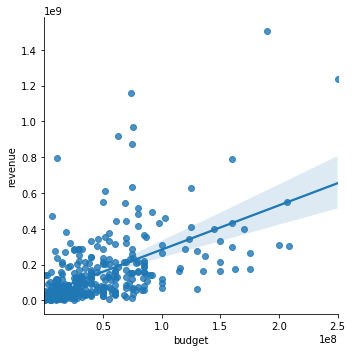

In [28]:
#GRAFICO LINEAR MODEL
sns.lmplot(
    data= data,
    x="budget", y="revenue",
    height=5
)


In [29]:
#CASA DI PRODUZIONE WARNER BROS
data1=df_H[df_H['production_companies'] == 6194]
#data1=data1[['budget','vote_average','name', 'label']]
data1 = data1.drop(['count'], axis=1)
data1

,_id,budget,original_title,production_companies,revenue,vote_average,vote_count,name,label
0,949,60000000,Heat,6194,187436818,7.7,1886.0,Warner Bros.,1
1,9273,30000000,Ace Ventura: When Nature Calls,6194,212385533,6.1,1128.0,Warner Bros.,0
2,9691,50000000,Assassins,6194,30303072,6.0,394.0,Warner Bros.,0
3,11859,50000000,Fair Game,6194,11534477,4.1,54.0,Warner Bros.,0
4,688,24000000,The Bridges of Madison County,6194,182016617,7.3,397.0,Warner Bros.,0
...,...,...,...,...,...,...,...,...,...
376,293167,185000000,Kong: Skull Island,6194,566652812,6.2,3161.0,Warner Bros.,0
377,274857,175000000,King Arthur: Legend of the Sword,6194,146175066,6.5,1506.0,Warner Bros.,0
378,417644,25000000,CHiPS,6194,26800152,6.2,277.0,Warner Bros.,0
379,353070,25000000,Going in Style,6194,84618541,6.6,543.0,Warner Bros.,0


In [30]:
#VEDO LE VARIE CORRELAZIONI
corr = data1.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            #square=True)

,_id,budget,revenue,vote_average,vote_count,label
_id,1.00,0.15,0.13,0.03,0.16,-0.08
budget,0.15,1.00,0.71,-0.11,0.57,-0.05
revenue,0.13,0.71,1.00,0.25,0.78,0.21
vote_average,0.03,-0.11,0.25,1.00,0.41,0.58
vote_count,0.16,0.57,0.78,0.41,1.00,0.39
label,-0.08,-0.05,0.21,0.58,0.39,1.00


In [31]:

#try to predict REVENUE  from BUDGET
from sklearn.model_selection import train_test_split
X1 = data1.budget.values.reshape(-1, 1)
y1 = data1.revenue.values 

x_train1, x_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size=0.33, random_state=42, shuffle=True)
print(x_train1.shape)
print(x_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(255, 1)
(126, 1)
(255,)
(126,)


In [32]:
#FACCIO UNA REGRESSIONE LINEARE
model1=LinearRegression(fit_intercept=True)
model1.fit(x_train1,y_train1)

LinearRegression()

In [33]:
y_pred_on_training1=model1.predict(x_train1)

In [34]:
y_pred1=model1.predict(x_test1)

In [35]:
#ANALIZZO L' ACCURATEZZA DEL MODELLO
from sklearn import metrics

R2_base1=metrics.r2_score(y_train1, y_pred_on_training1, sample_weight=None, multioutput='uniform_average')
R21=metrics.r2_score(y_test1, y_pred1, sample_weight=None, multioutput='uniform_average')

print("R2 on training data: ",R2_base1)
print("R2 on test data: ",R21)

R2 on training data:  0.5280907890554829
R2 on test data:  0.38004753962575166


In [36]:
coefficients1= model1.coef_
print("Intercept: ", model1.intercept_)
print("Coefficients: ")
print(coefficients)

Intercept:  -13673305.429218203
Coefficients: 
[2.6214257]


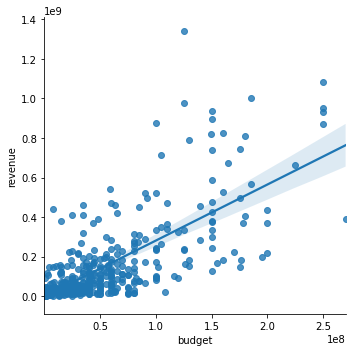

In [37]:
#GRAFICO PER LA WARNER BROS
g = sns.lmplot(
    data= data1,
    x="budget", y="revenue",
    height=5
)